In [20]:
import os
import io
import time
import math
import random
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import joblib
import tempfile

import os, warnings
# Tell loky how many cores to use so it won't call `wmic`
os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count() or 1)

# (Optional) silence this specific warning completely
warnings.filterwarnings(
    "ignore",
    message="Could not find the number of physical cores",
    category=UserWarning
)


# ---------------------------
# Configuration
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Windows paths (use raw strings)
REGULAR_DIR = r"c:\shen\UM_grant\VentureWell\BulgingCell\Images\0_Regular"
BULGING_DIR = r"c:\shen\UM_grant\VentureWell\BulgingCell\Images\1_Bulging"

IMG_SIZE = (128, 128)
USE_GRAYSCALE = True     # set False to use RGB (much higher dimensional)
AUG_PER_IMAGE = 2        # how many augmented samples per training image (0 to disable)
TEST_SIZE = 0.20

In [21]:
# ---------------------------
# Utilities
# ---------------------------
def is_image_file(p: Path) -> bool:
    return p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def load_and_preprocess(path: Path, img_size: Tuple[int, int], grayscale: bool = True) -> np.ndarray:
    """Load an image file and return a flattened numpy array after resizing (and grayscale if chosen)."""
    with Image.open(path) as img:
        # Convert
        if grayscale:
            img = img.convert("L")
        else:
            img = img.convert("RGB")
        # Resize with high-quality resampling
        img = img.resize(img_size, Image.BICUBIC)
        arr = np.asarray(img, dtype=np.float32)
        # Normalize to [0,1]
        arr = arr / 255.0
        # Flatten
        return arr.flatten()

def augment_pil(img: Image.Image) -> Image.Image:
    """Apply a random but mild augmentation to a PIL Image and return an augmented PIL Image."""
    # Random horizontal flip
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    # Small rotation (-10° to 10°)
    angle = random.uniform(-10, 10)
    img = img.rotate(angle, resample=Image.BICUBIC, expand=False, fillcolor=0 if img.mode == "L" else (0, 0, 0))
    # Slight translation (±5% of size)
    tx = int(random.uniform(-0.05, 0.05) * img.width)
    ty = int(random.uniform(-0.05, 0.05) * img.height)
    img = img.transform(img.size, Image.AFFINE, (1, 0, tx, 0, 1, ty), resample=Image.BICUBIC, fillcolor=0 if img.mode == "L" else (0, 0, 0))
    # Brightness jitter (0.8–1.2)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(random.uniform(0.8, 1.2))
    return img

def pil_from_array_feature(x: np.ndarray, img_size: Tuple[int, int], grayscale: bool) -> Image.Image:
    """Reconstruct a PIL Image from feature vector for augmentation previews (used only on training set)."""
    if grayscale:
        arr = (x.reshape(img_size) * 255.0).clip(0, 255).astype(np.uint8)
        return Image.fromarray(arr, mode="L")
    else:
        c = 3
        arr = (x.reshape(img_size[1], img_size[0], c) * 255.0).clip(0, 255).astype(np.uint8)
        return Image.fromarray(arr, mode="RGB")

def model_size_kb(model) -> float:
    import io, joblib
    buf = io.BytesIO()
    joblib.dump(model, buf, compress=3)
    return len(buf.getvalue()) / 1024.0

def avg_inference_time_ms(model, X: np.ndarray) -> float:
    """Average per-image inference time in milliseconds."""
    # Measure single-sample prediction time to be comparable across models
    start = time.perf_counter()
    for i in range(X.shape[0]):
        _ = model.predict(X[i:i+1])
    elapsed = time.perf_counter() - start
    return (elapsed / X.shape[0]) * 1000.0

In [22]:
# ---------------------------
# Load dataset
# ---------------------------
def load_dataset(regular_dir: str, bulging_dir: str, img_size: Tuple[int, int], grayscale: bool) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for label, folder in [(0, regular_dir), (1, bulging_dir)]:
        for p in Path(folder).rglob("*"):
            if p.is_file() and is_image_file(p):
                try:
                    feat = load_and_preprocess(p, img_size, grayscale=grayscale)
                    X.append(feat)
                    y.append(label)
                except Exception as e:
                    print(f"[WARN] Skipped {p} due to error: {e}")
    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    return X, y

print("Loading images...")
X, y = load_dataset(REGULAR_DIR, BULGING_DIR, IMG_SIZE, USE_GRAYSCALE)
print(f"Loaded {X.shape[0]} images. Feature dim = {X.shape[1]}")

Loading images...
Loaded 215 images. Feature dim = 16384


In [23]:
# ---------------------------
# Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)

In [24]:
# ---------------------------
# Data augmentation on training set
# ---------------------------
if AUG_PER_IMAGE > 0:
    print(f"Augmenting training data (x{AUG_PER_IMAGE})...")
    aug_features = []
    aug_labels = []
    # Reconstruct minimal PIL image from features for augmentation
    for xi, yi in zip(X_train, y_train):
        img = pil_from_array_feature(xi, IMG_SIZE, USE_GRAYSCALE)
        for _ in range(AUG_PER_IMAGE):
            aug_img = augment_pil(img.copy())
            aug_img = aug_img.resize(IMG_SIZE, Image.BICUBIC)
            arr = np.asarray(aug_img, dtype=np.float32) / 255.0
            aug_features.append(arr.flatten())
            aug_labels.append(yi)
    if aug_features:
        X_aug = np.vstack(aug_features).astype(np.float32)
        y_aug = np.array(aug_labels, dtype=np.int64)
        X_train = np.vstack([X_train, X_aug])
        y_train = np.concatenate([y_train, y_aug])
        print(f"Training set after augmentation: {X_train.shape[0]} samples")

Augmenting training data (x2)...
Training set after augmentation: 516 samples


In [25]:
# ---------------------------
# Define models
# ---------------------------
models: Dict[str, Pipeline] = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler(with_mean=True)),
        ("clf", LogisticRegression(
            solver="saga", penalty="l2", max_iter=5000, random_state=SEED, n_jobs=-1))
    ]),
    "SVM_RBF": Pipeline([
        ("scaler", StandardScaler(with_mean=True)),
        ("clf", SVC(kernel="rbf", probability=False, random_state=SEED))
    ]),
    "DecisionTree": Pipeline([
        ("scaler", "passthrough"),
        ("clf", DecisionTreeClassifier(max_depth=None, random_state=SEED))
    ]),
    "RandomForest": Pipeline([
        ("scaler", "passthrough"),
        ("clf", RandomForestClassifier(
            n_estimators=300, max_depth=None, n_jobs=-1, random_state=SEED))
    ]),
    "KNN_k5": Pipeline([
        ("scaler", StandardScaler(with_mean=True)),
        ("clf", KNeighborsClassifier(n_neighbors=5, weights="distance"))
    ]),
    "MLP_1x256": Pipeline([
        ("scaler", StandardScaler(with_mean=True)),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(256,), activation="relu", solver="adam",
            learning_rate_init=1e-3, max_iter=200, random_state=SEED, early_stopping=True))
    ]),
}

In [26]:
# ---------------------------
# Train, evaluate, report
# ---------------------------
def evaluate_model(name: str, pipe: Pipeline, X_train: np.ndarray, y_train: np.ndarray,
                   X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
    print(f"\n=== Training {name} ===")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="binary", zero_division=0)
    rec = recall_score(y_test, y_pred, average="binary", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="binary", zero_division=0)

    # Inference latency
    inf_ms = avg_inference_time_ms(pipe, X_test)

    # Model size
    size_kb = model_size_kb(pipe)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "inference_ms_per_image": inf_ms,
        "model_size_kb": size_kb
    }

results = {}
for name, pipe in models.items():
    metrics = evaluate_model(name, pipe, X_train, y_train, X_test, y_test)
    results[name] = metrics


=== Training LogisticRegression ===

=== Training SVM_RBF ===

=== Training DecisionTree ===

=== Training RandomForest ===

=== Training KNN_k5 ===

=== Training MLP_1x256 ===


In [27]:
# ---------------------------
# Print results in a table
# ---------------------------
def nice(num, digits=4):
    if isinstance(num, (int, np.integer)):
        return str(num)
    return f"{num:.{digits}f}"

headers = ["Model", "Accuracy", "Precision", "Recall", "F1", "ms/img", "Size (KB)"]
col_widths = [max(len(h), 14) for h in headers]

def print_row(cols):
    print(" | ".join(str(c).ljust(w) for c, w in zip(cols, col_widths)))

print("\n\n===== Evaluation Results =====")
print_row(headers)
print("-" * (sum(col_widths) + 3 * (len(headers) - 1)))
for name, m in results.items():
    row = [
        name,
        nice(m["accuracy"]),
        nice(m["precision"]),
        nice(m["recall"]),
        nice(m["f1"]),
        nice(m["inference_ms_per_image"]),
        nice(m["model_size_kb"])
    ]
    print_row(row)



===== Evaluation Results =====
Model          | Accuracy       | Precision      | Recall         | F1             | ms/img         | Size (KB)     
--------------------------------------------------------------------------------------------------------------------
LogisticRegression | 0.8837         | 0.9000         | 0.8571         | 0.8780         | 1.2016         | 398.2617      
SVM_RBF        | 0.8372         | 0.8889         | 0.7619         | 0.8205         | 9.7645         | 17568.0078    
DecisionTree   | 0.8140         | 0.8421         | 0.7619         | 0.8000         | 0.7294         | 1.9053        
RandomForest   | 0.9070         | 0.9048         | 0.9048         | 0.9048         | 69.3426        | 277.2539      
KNN_k5         | 0.7674         | 0.9231         | 0.5714         | 0.7059         | 444.1378       | 30028.8291    
MLP_1x256      | 0.7907         | 0.8000         | 0.7619         | 0.7805         | 2.3892         | 46092.0049    


In [28]:
# Optional: brief class balance check
unique, counts = np.unique(y, return_counts=True)
print("\nClass counts (full dataset):", dict(zip(unique.tolist(), counts.tolist())))
print("Train size:", X_train.shape[0], " Test size:", X_test.shape[0])
print("Done.")


Class counts (full dataset): {0: 112, 1: 103}
Train size: 516  Test size: 43
Done.


In [29]:
from sklearn.model_selection import StratifiedKFold, cross_validate

# --- Random Forest config (match your earlier params if desired) ---
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=SEED,
    n_jobs=1  # use 1 to avoid loky/wmic warnings on Windows
)

# --- 5-fold Stratified CV ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Scoring: binary classification assumes class "1" is positive
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

cv_results = cross_validate(
    rf, X, y,
    scoring=scoring,
    cv=cv,
    return_train_score=False,
    n_jobs=1  # parallelize if you've set LOKY_MAX_CPU_COUNT
)

# --- Print per-fold metrics ---
print("===== 5-Fold CV: Random Forest =====")
for i in range(cv.get_n_splits()):
    print(f"Fold {i+1}: "
          f"Acc={cv_results['test_accuracy'][i]:.4f}  "
          f"Prec={cv_results['test_precision'][i]:.4f}  "
          f"Rec={cv_results['test_recall'][i]:.4f}  "
          f"F1={cv_results['test_f1'][i]:.4f}")

# --- Print mean ± std ---
def mean_std(arr):
    return np.mean(arr), np.std(arr, ddof=1)

acc_m, acc_s = mean_std(cv_results['test_accuracy'])
pre_m, pre_s = mean_std(cv_results['test_precision'])
rec_m, rec_s = mean_std(cv_results['test_recall'])
f1_m,  f1_s  = mean_std(cv_results['test_f1'])

print("\nOverall (mean ± std):")
print(f"Accuracy : {acc_m:.4f} ± {acc_s:.4f}")
print(f"Precision: {pre_m:.4f} ± {pre_s:.4f}")
print(f"Recall   : {rec_m:.4f} ± {rec_s:.4f}")
print(f"F1-score : {f1_m:.4f} ± {f1_s:.4f}")

===== 5-Fold CV: Random Forest =====
Fold 1: Acc=0.9535  Prec=1.0000  Rec=0.9000  F1=0.9474
Fold 2: Acc=0.9535  Prec=0.9500  Rec=0.9500  F1=0.9500
Fold 3: Acc=0.9535  Prec=0.9524  Rec=0.9524  F1=0.9524
Fold 4: Acc=0.9767  Prec=0.9545  Rec=1.0000  F1=0.9767
Fold 5: Acc=0.9302  Prec=0.9091  Rec=0.9524  F1=0.9302

Overall (mean ± std):
Accuracy : 0.9535 ± 0.0164
Precision: 0.9532 ± 0.0322
Recall   : 0.9510 ± 0.0354
F1-score : 0.9513 ± 0.0167


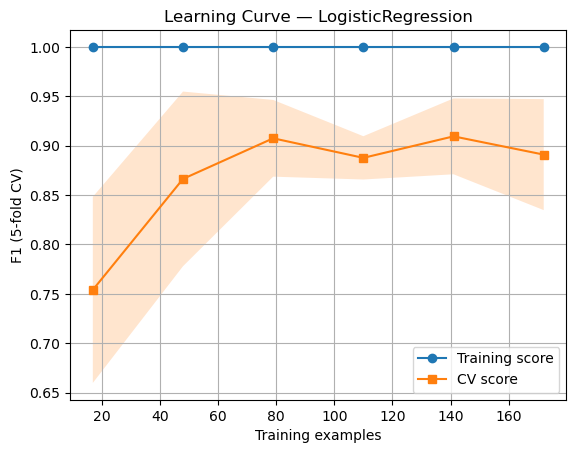

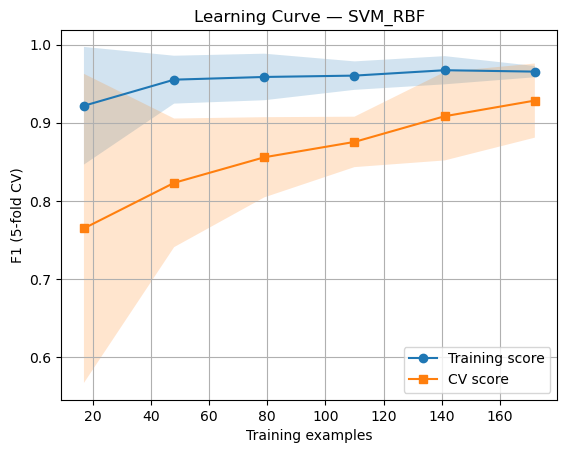

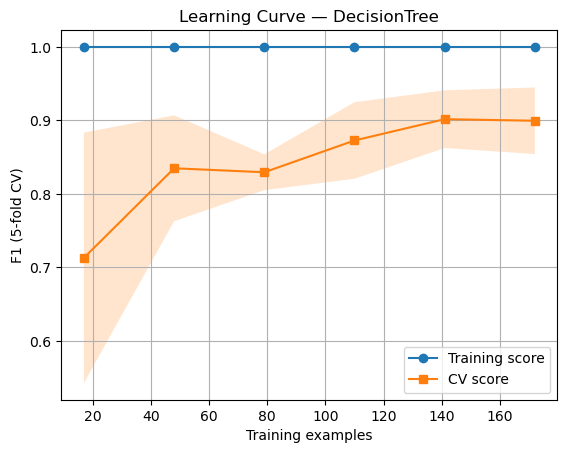

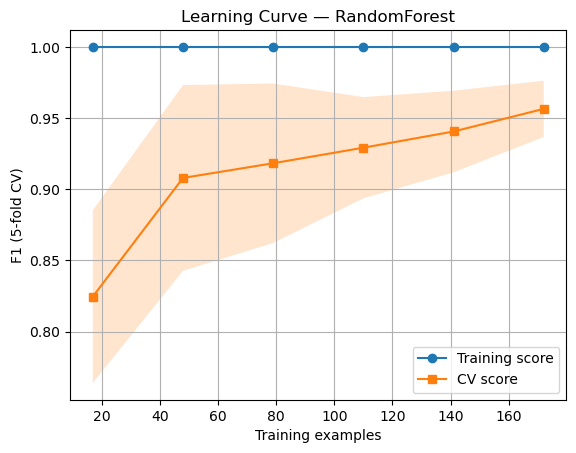

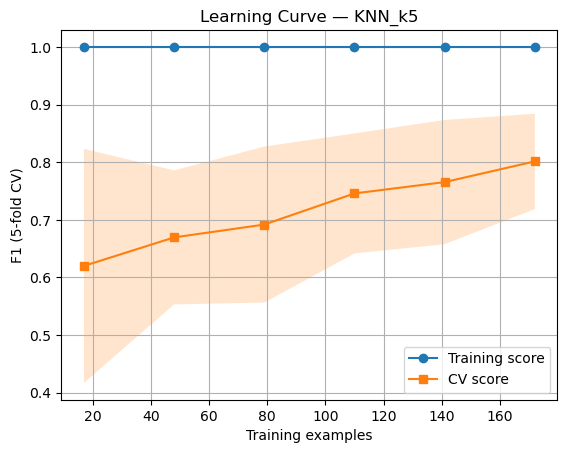

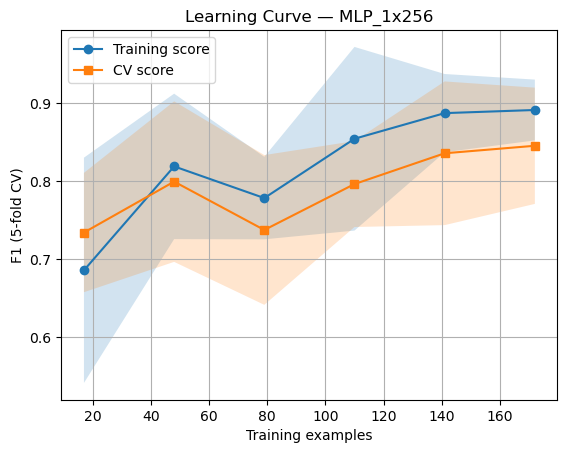

Training MLP once to capture loss curve...


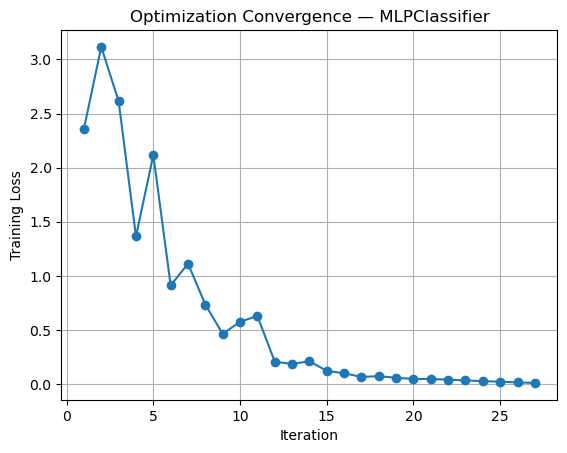


===== Hyperparameters (classifier step) =====

--- LogisticRegression ---
{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 5000,
 'multi_class': 'deprecated',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

--- SVM_RBF ---
{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

--- DecisionTree ---
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter

In [30]:
# --- Convergence (learning) curves for all models + training loss curve for MLP ---

from sklearn.model_selection import StratifiedKFold, learning_curve
import matplotlib.pyplot as plt

# CV settings (matches your earlier usage)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def plot_learning_curve_for_pipeline(name, pipe, X, y, cv, n_jobs=1):
    train_sizes, train_scores, val_scores = learning_curve(
        pipe, X, y,
        cv=cv,
        n_jobs=n_jobs,
        scoring="f1",              # use F1 as a balanced signal; change to "accuracy" if you prefer
        train_sizes=np.linspace(0.1, 1.0, 6),
        shuffle=True,
        random_state=SEED
    )
    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1, ddof=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1, ddof=1)

    plt.figure()
    plt.title(f"Learning Curve — {name}")
    plt.xlabel("Training examples")
    plt.ylabel("F1 (5-fold CV)")
    # shaded std (no explicit colors per your tooling best practices)
    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.fill_between(train_sizes, val_mean-val_std,     val_mean+val_std,     alpha=0.2)
    plt.plot(train_sizes, train_mean, marker="o", label="Training score")
    plt.plot(train_sizes, val_mean,   marker="s", label="CV score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Plot learning curves for every model in your dictionary
for name, pipe in models.items():
    # If you set the WMIC workaround earlier, you can raise n_jobs to speed this up
    plot_learning_curve_for_pipeline(name, pipe, X, y, cv=cv, n_jobs=1)

# --- True optimization (loss) convergence curve for the MLP only ---
if "MLP_1x256" in models:
    print("Training MLP once to capture loss curve...")
    mlp_pipe = models["MLP_1x256"]
    # Fit on the training split (not CV) to obtain the iterative loss trajectory
    mlp_pipe.fit(X_train, y_train)
    mlp = mlp_pipe.named_steps["clf"]
    if hasattr(mlp, "loss_curve_") and mlp.loss_curve_:
        plt.figure()
        plt.title("Optimization Convergence — MLPClassifier")
        plt.xlabel("Iteration")
        plt.ylabel("Training Loss")
        plt.plot(range(1, len(mlp.loss_curve_)+1), mlp.loss_curve_, marker="o")
        plt.grid(True)
        plt.show()
    else:
        print("[INFO] No loss_curve_ available (try increasing max_iter or disable early_stopping).")

# --- Print hyperparameters of each model (classifier step of the pipeline) ---

from pprint import pprint

def print_model_hyperparams(models_dict):
    print("\n===== Hyperparameters (classifier step) =====")
    for name, pipe in models_dict.items():
        clf = pipe.named_steps["clf"]
        print(f"\n--- {name} ---")
        # Keep it tidy: only the classifier's own params (not the entire pipeline)
        params = clf.get_params(deep=False)
        pprint(params)

print_model_hyperparams(models)